# Week 10: Networks 2


Networks are mathematical representations of complex systems. We can use networks to gain various statistical insight about the system we're representing, and we can look for patterns at the meso-scale by employing *community detection* algorithms. This week we will explore the following:

* Network null models
* How to use a null model to infer the p-value of a result
* How a popular community detection algorithm works (and fails)

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [87]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx           # `pip install networkx`
import json
from collections import Counter
import community                # `pip install python-louvain` or `conda install -c auto python-louvain`

## Exercises

### Part 1: Network null models

**What is a null model?** Null models are alternative instances of data, that are used to assess the amount of signal that is due to pure randomness. For example, you might have
measured some signal in your data, like a large number of triangles (high average local clustering coefficient)
in your network, but before you go and report that to your boss you need to answer one crucial question: how does
this result compare with a *random* one? In other words, how can you be so sure that this high number of triangles
measured is not perfectly normal even in a random network of similar origin and therefore not very special after all? The answer: **you
create a null model to compare your result with!**

> Note: null models are a concept from the general field of statistics and therefore not just specific to
networks. You can use this statistical tool anytime you need to assess how likely it is that your result is random.

The most common type of null model is one where you shuffle links in your network, while preserving the degree
sequence. *(Recall, that the degree sequence is a list that stores the degree of each node. So if we shuffle and
preserve the degree sequence at the same time, it means that after all the link-shuffling is done, nodes will
have new neighbors, but the same number of neighbors)*. In this shuffled network (the null model), if you find that
there are far fewer triangles than in your real data then you can start to argue that your result is significant.

> Note: the term *null model* is a slight misnomer, as it is not a model per se, but rather an instance of the
data that is permuted in some way (usually under constraints, such as preservation of degree sequence), so it can
be taken to represent *randomness*. As such, there is no *model*, but rather an *instance* or simply *data*.

But that is just one comparison. What if the number of triangles in the random data–the null model–is smaller, but
not that much smaller? Can you still say your result is significant? Well, the trick (although computationally expensive
as you will come to learn) is to do MANY comparisons. 1000 is not a bad start. For each comparison, you check if
the number of triangles in your real data is bigger. After you have compared one thousand times you compute **the
fraction of times** your number of triangles in the real data was bigger than in the random data. Guess what that
number (between 0 and 1) is called? **The p-value**. And what does it communicate? **The probability that your result
is random!**

^ That's some useful statistics right there!

Please make sure you have **READ AND UNDERSTOOD** the above, as you will otherwise have a very hard time completing the
following exercises.

**Ex. 10.1.1**: The method described above works for anything you might want to measure in a network. Let's say,
instead of measuring the number of triangles, you measured the network diameter. Explain in your own words how to
assess the statistical significance (the p-value) of such a measurement, using the same null model.

#### Solution to Ex. 10.1.1

First, we define the metric of 'network diameter' : "It is the shortest distance between the two most distant nodes in the network. In other words, once the shortest path length from every node to all other nodes is calculated, the diameter is the longest of all the calculated path lengths." (Wiki)

Here, we use the measure of the network diameter as a given signal of our network. The objective is to asses the sigificance of our observation compared to a random network. Here, we apply a null model, where we compare the measure (network diameter) with the same measure in a random network. The apply the following procedure for the null-model:
- We apply a common type of null model where we shuffle links in the network (like a bootstrap) while preserving the degree sequence/distribution (same number of nodes, but new neighbors - we consider this shuffled network our null model). This we can compare with the true network based on the metric of network diameter
- We compute 1.000 of these random networks and compare each with the true network (the real data) based on the metric of network diameter
- Based on the 1.000 comparisons, we compute the fraction of times that the signal from the random graphs is greater than the signal from our real network (the true data) - This fraction we call the p-value which denotes the probability of our result being random. (thus, if our real data yields an metric value far greater than the ones observed in the random graphs, then we find a very low fraction and therefore we conclude that our signal is significant and therefore "random" with a low probability).
- Thus, the null is that the network is random -> if we obtain a low fraction (thus, a low p-value under some critical fraction value), then our network is NOT random (or ... we reject that it is random) as the shortest distance between the two most distant nodes in the network is significantly smaller than a random network in genereal (where "in general" refers to the loop of 1.000 random networks which we assume to be a nice base case for generality). On the other hand, if we obtain a high p-value, then we fail to reject that the network diameter could come from a random network / the signal could be due to pure randomness.


However, there seems to be a mistake in the intro text for the definition of the p-value:

"For each comparison, you check if the number of triangles in your real data is bigger. After you have compared one thousand times you compute the fraction of times your number of triangles in the real data was bigger than in the random data"

I guess this should be the other way around: the fraction of times that the signal of the null models is greater than the signal from the real data network - if this fraction is very small (for instance if the signal of average local cluster coefficients is much larger for the real data graph in general / large number of times), then it corresponds to a low p-value -> this we interpret the way that the signal from my real data network is significant and therefore random with a low probability.

**Ex. 10.1.2**: The null model described above rewires a network while preserving the degree distribution. [Here](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html#networkx.algorithms.swap.double_edge_swap) is
implementation of it in NetworkX. In your own words, describe:
1. how it works and why it achieves randomness
without changing the degree distribution.
2. Also describe what can sometimes happen and why the desired number of swaps `nswaps` is only an upper-bound on
the number of swaps.

#### Solution to Ex. 10.1.2

The algorithm takes as input an graph with a specified number of nodes and edges. Thus, one can compute the degree distribution for this graph (number of times a given node has n number of edges - one can make a histrogram to show this distribution).

The algorithm works by keeping the node degrees fixed (on an overall basis) while trying to create new edges between nodes - thus, shuffling the same edges around between new nodes (where the old edges are "deleted"). It tries a given number of random swaps between nodes - if the edge already existed, then no swap is made and it tries again until finding a "suitable edge pair" as is stated in the documentation. The algortihm takes in the following inputs:

- A networkx.Graph object G 
- nswap (integer, where default is 1) : this is the number of double-edge swaps to perform, where a double-edge swap is defined as removing two randomly chosen edges (u-v and x-y) and creating a new edge pair (u-x and v-y).
- max_tries (integer) : this is a specifiction of the max number of tries to swap edges
- seed : is controls the randomness of the algortihm - for the same number of seed / random State, the algorithm will produce the same outcome

The output of the algorithm is a new (random) graph where the double edge swaps has been performed.

**Ex. 10.1.3**: Load the Facebook wall-post network from last week, into a `networkx.Graph` object called `G`.
1. Measure the average local clustering coefficient (ALCC) of `G`. Print it.
2. Over 1000 iterations, measure the ALCC for `G` where, in each iteration, you have made 1000 edge swaps using 
`double_edge_swap`. Append the measured ALCC values to a list. Print the average of this list. *Note: this will
obviously take some time**.
3. Report the p-value of your result, the ALCC of the real data.
4. Make a histogram that displays the distribution of ALCC values in the null models as a histogram as well as
the ALCC of the real data as a vertical line. Comment on this result. Does it make sense?

In [88]:
# Loading the facebook data

import pandas as pd
import gzip

f = gzip.open('facebook-wall.txt.gz') 

data = pd.read_csv(
    f,
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)
f.close()

# Creating the graph using the same code as in Ex 9 - however, we construct G as an undirected graph (for the average_clustering algorithm to work)
# We notice that all edges have the same "default" weight of 1
import networkx as nx
data_1 = data.groupby(['user1', 'user2']).size().reset_index(name='weight')
G = nx.from_pandas_edgelist(data_1, 'user1', 'user2', 'weight', create_using=nx.Graph) # Changed to non-directed graph
G

In [89]:
# Measure the average local clustering coefficient (ALCC) of G:

# We define the Watts-Strogatz average local clustering coefficient as an average of 
# clustering coefficient over all of the nodes in the network. 
#Thus, for every single node, we compute the clustering coefficient which measures how complete the neighborhood of a node is, and average over all of them

alcc_real_data = nx.average_clustering(G) 
print(alcc_real_data)

0.10796398386235195


In [90]:
import numpy as np
from tqdm import tqdm

ALCC_list = []

for i in tqdm(range(1000)): #adding the progress bar as suggested in the writeup
    G_i = nx.double_edge_swap(G, 1000, 10000) # needs nswap < ntries
    ALCC_i = nx.average_clustering(G_i)
    ALCC_list.append(ALCC_i)
print('Done')

# The average ALCC of the list:
mean_alcc = np.mean(ALCC_list)
print(mean_alcc)


100%|██████████| 1000/1000 [1:02:28<00:00,  3.75s/it]

Done
0.004416463317685757


P value =  0.0


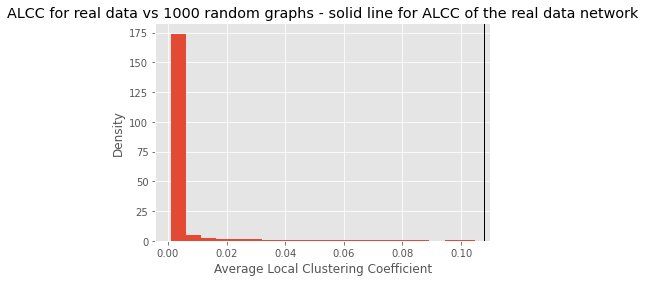

In [95]:
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')

# compute fraction / p-value 
p_val = len([d for d in ALCC_list if d>alcc_real_data]) / len(ALCC_list)
print('P value = ', p_val)

# plot:
plt.hist(ALCC_list, density=True,bins=20)  #bins=30 `density=False` would make counts
plt.ylabel('Density')
plt.xlabel('Average Local Clustering Coefficient')
#plt.axvline(mean_alcc, color='black', linestyle='dashed', linewidth=1) 
plt.axvline(alcc_real_data, color='black', linewidth=1)
plt.title('ALCC for real data vs 1000 random graphs - solid line for ALCC of the real data network')
plt.show()

It sems as the average local clustering coefficient for the facebook data is highly significant (p-value = 0.0)


### Part 2: Community detection

Communities are little lumps of nodes in a network that are unusually strongly connected. Your family is a community, and your friend group from work or university is another community. While there is no one true definition of what a community is, there are many many different methods and algorithms for finding them. Here we will work with one of the most popular ones: [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity). The following exercises will walk you through the fundamentals of this method, and finally have you apply it to the network you used last week.

#### The modularity function

> **Ex. 10.2.1**: Assume you have a network where nodes and links tend to form lumps here and there. Imagine you now reach for your pen, and start labeling these nodes with group names (or ids) that feel appropriate according to how they are lumped together. If your partition is "good", nodes that are connected in groups should intuitively have the same label, while nodes that are distant and disconnected should have different labels. Modularity is a function that can be used to measure, by this logic, *how good* your partition is. It is in technical terms a *utility function*, and it looks like this:
> <br><br>
> $$ Q = \dfrac{1}{2m}\sum_{ij}{\left[A_{ij}-\dfrac{k_ik_j}{2m}\right]\delta(c_i, c_j)}.$$
> <br>
> Your job in this problem is to explain this equation. When I look at daunting math I find it calming to try and read it as if it were code. Since all math can be implemented in code, all math can be broken into parts, where each part does a seperate thing. Answer each question below seperately:
1. In code, a sum, $\sum$, is like a `for` loop, where in every iteration you increment a variable. In the equation for modularity the little $ij$ subscript tells is what the sum is looping over (like `for ij in sumloop`). But what is $ij$?
2. In each iteration of the sum, the delta function $\delta(c_i, c_j)$ is used, where $c_i$ is the community label of node $i$. The delta function is a very simple program that returns 0 if the two input values are different and 1 if they are they same. How would you implement the delta function in code? What is it used for in the modularity equation?
3. Inside the sum we use the term $\frac{k_ik_j}{2m}$ as our *null model*. $k$ is the degree sequence (so $k_i$ is the degree of node $i$) and $m$ is the sum of all link weights. Explain what this null model measures. Could we have used other null models?
4. The sum subtracts the null model from $A_{ij}$ and adds the result to its final value if the delta function evaluates to 1. What is the point of only summing over this difference when the delta function is 1?
5. The sum term is normalized by $2m$. Why exactly $2m$?
6. Summarize your insight gained from answering the above questions. In your own words, explain how the modularity function works. Use 1-3 sentences.


#### Solution to 10.2.1 

1) ij denotes the different edges / pairs of nodes in the network, that are connected. Thus, the summation runs oer all the edges ij in the graph

2 & 4) The delta function could be implemented using a indicator function as stated in the writeup of the form: int(a == b). Another way to implement this is by doing a nested for loop (I implement this in my code below). The delta function ensures that only nodes that are located in the same community/cluster contributes to the score of Q (where we can think of Q as a cluster quality measure)

3) The term $\frac{k_ik_j}{2m}$ is considered the probability of a edge between node i and node j. Thus, this expected weight represents the expected number of edges in a random graph - in this way the modularity quation includes a comparison of our real data with a potentiel random graph outcome WITHOUT having to compute/simulate a random graph/null model as we only use "real data" - this is a nice feature of the score function. To sum up, the inside of the brackets is the excess connectivity compared to a random network with randomly placed edges.


5) The scaling of 2m is considered a normalization of the modularity by the total number of pairs to create edges with.

6) Summary:

Modularity is a signal/metric that allows us to quantify the quality of connectivity of nodes to communities - this is done by evaluating/measuring how much more densely connected the nodes within a community are compared to how connected they would be in a random network on average.


> **Ex. 10.2.2**: Implement the modularity function. Write a Python function that takes as input an adjacency matrix and a label vector, and returns the modularity. Compute and print the modularity for the ones given below. The correct result is 0.122.

In [96]:
# Solution to Ex 10.2.2:

import numpy as np

A = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
])

c = [0, 0, 0, 0, 1, 1]

def modularity(A, c):
    """Compute modularity for a labeled network.
    
    Input
    -----
        A : numpy.array
            Adjacency matrix. (N, N) square matrix.
        c : list of ints
            Community labels. Length N.
    
    Output
    ------
        out : float
    """
    # Your beautiful code goes here
    
    # Computing N - the adjacency matrix is (N x N) by definition
    N = A.shape[0] 
    
    # computing m:
    m = A.sum()/2 # dividing with 2 to avoid double counting
    
    # Computing the elements in the sum
    sum_ = 0
    
    for i in range(N):
        for j in range(N):
            if c[i] == c[j]:
                res = A[i][j]-(sum(A[i]))*(sum(A[j]))*(1/(2*m))
                sum_ = sum_ + res
    return sum_/(2*m)
    
print('The modularity score for A is :', modularity(A, c).round(4))

The modularity score for A is : 0.1224


In [97]:
# Comparing with the function given in the writeup:

def delta(a,b):
    return int(a == b)


def modularity_writeup(A, c):
    n = A.shape[0] # Matrix is symmetric
    Q = 0
    m = A.sum() / 2
    for i in range(n):
        ki = A[i,:].sum()
        for j in range(n):
            kj = A[:,j].sum()
            Q += (A[i,j] - ki*kj/(2*m)) * delta(c[i], c[j])
    return Q/(2*m)

round(modularity_writeup(A, c),4)

# I notice that I get the same result


0.1224

> **Ex. 10.2.3**: The example labeling, `c`, was not optimal. Find the optimal one and print its modularity score.

>*Hint: Either just try a bunch of different label combinations or visualize the network so you can see what is optimal. Using pen and paper here is no shame.*

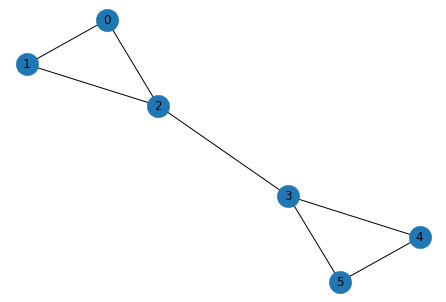

The modularity score is : 0.3571


In [98]:
# Drawing the graph:
rows, cols = np.where(A == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=500, with_labels=True)
plt.show()

# We notice that there is two communities - one with nodes 0,1,2 and one with nodes 3,4,5. We compute the modularity score for the two community split:
c_2 = [0, 0, 0, 1, 1, 1]
print('The modularity score is :',modularity(A, c_2).round(4))

# We notice that this modularity score is greater for c_2 than the first one based on c

#### Finding the best communities

OK, so we are now able to evaluate the quality of a partition. But how do we find the best partition? Modularity gives us a way to measure *how good* our partition is, but it does not tell of how to find the best one. For that we need some sort of algorithm. The *Louvain method* is that algorithm.

It works in the following steps:
1. Set every node to be its own community (initiate `c = [0, 1, 2, 3, 4, 5]`).
2. Compute the modularity.
3. Now pick a random node.
    1. For every neighbor it has, try giving it the neighbor's label, and compute the change in modularity.
    2. If any of those relabelings led to an increase in modularity, choose the relabeling with the greatest increase.
4. Repeat 2-3 until modularity ceases to increase for any relabelings.

> **Ex. 10.2.BONUS**: Implement the Louvain method, and show that it gives the labeling for `A`. A cool portfolio project for your Github account here!

#### Communication communities on Facebook

Now let's work with some real data. Whip out the network you created **last week**, we will be using that again. Apply again the **threshold** you created in **Ex. 9.2.4**.

> **Ex. 10.2.4**: Find the communities in this networks. Print the number of communities and plot the distribution of community sizes. See something interesting? Comment on this distribution.

>*Hint: You're welcome to use your own implementation of the Louvain algorithm (pretty badass if you can), but there's also a widely used Python implementation that you can take off the shelf. Go ahead and install `python-louvain` by running `conda install -c auto python-louvain` in a terminal. After installation, import it with `import community`, and use `community.best_partition` to get a node-community dictionary.*

In [99]:
import networkx as nx

def time_slice(t0, t1, data):
    #t0 = data.timestamp.max() - 86400 * 7  # Lower bound of time-slice (here: 7 days before last wall post)
    #t1 = data.timestamp.max()              # Upper bound of time-slice

    # Subset of the pandas dataframe
    data_t = data.loc[data.timestamp.between(t0, t1)]

    # Count the number of times each link occurs and store that in a new 'weight' column
    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')

    # Create a `nx.DiGraph` from this dataframe
    G_t = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph) # Changed to non-directed graph 
    
    return G_t

In [100]:
import collections
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gzip

# Importing facebook data once again
f = gzip.open('facebook-wall.txt.gz') 

data = pd.read_csv(
    f,
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)
f.close()

#  --- || Copy code from 9.2.4 || ---
data_sliced = data[:20000]

# Defining time stamps
t0 = data_sliced.timestamp.max() - 86400 * 365
t1 = data_sliced.timestamp.max()            

# Create the `nx.DiGraph`
G_w = time_slice(t0, t1, data=data_sliced)

# Having a look at nodes and edges
print("Nodes: %d & Edges: %d" %(len(G_w.nodes), len(G_w.edges)))  


Nodes: 5203 & Edges: 8628


Number of comminities :  2


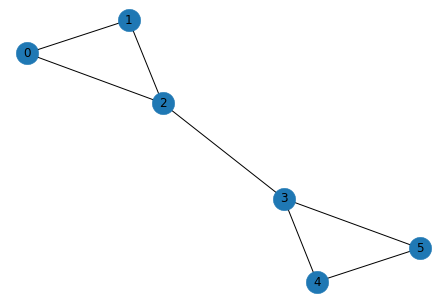

In [101]:
# testing best comminities on A:

import community
# Finding the optimal number of comminities
test = community.best_partition(nx.Graph(A))

# Printing the optimal number of comminities
print('Number of comminities : ',len(np.unique(list(test.values()))))

rows, cols = np.where(A == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=500, with_labels=True)
plt.show()


Number of comminities :  549


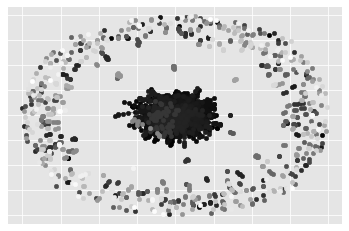

In [102]:
# Solution to 10.2.4:
import community

partition = community.best_partition(G_w)

print('Number of comminities : ',len(np.unique(list(partition.values()))))

# Drawing with networkx
size = float(len(set(partition.values())))
pos = nx.spring_layout(G_w)
count = 0.
for com in set(partition.values()) :
    count += 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G_w, pos, list_nodes, node_size = 20, node_color = str(count / size))
nx.draw_networkx_edges(G_w, pos, alpha=0.5)
plt.show()

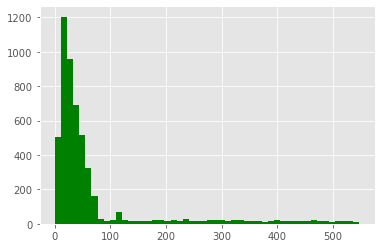

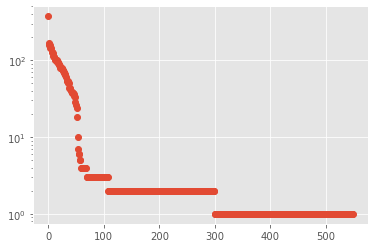

In [103]:
# Drwing histogram
import matplotlib.pyplot
from matplotlib import style
plt.style.use('ggplot')

# Distribution of communities
plt.hist(partition.values(), density=False,bins=50, color='g') # partition.values(),list(partition.keys())
plt.show()

#  - we notice some comminities are large (>1000 nodes interconnected), while a lot of comminities (more than 400) are relatively small

# Comparing with the method given in the writeup
cluster, counts = zip(*Counter(partition.values()).items())
plt.plot(sorted(counts, reverse = True), 'o')
plt.yscale('log')
plt.show()

> **Ex. 10.2.5**: Visualize the network, similarly to how you did it last week but this time coloring the nodes by their labels.
>
> *Hint: [Here](https://netwulf.readthedocs.io/) are the `netwulf` docs. Fiddle around with the layout a little it always makes the network look nicer.*

In [104]:
import netwulf as nw

# We use the 'group' attribute to color/visualize the nodes in specific communities
nx.set_node_attributes(G_w, partition, 'group')

# Visualize
from netwulf import visualize
nw.visualize(G_w, config={'zoom':2.3})

(None, None)

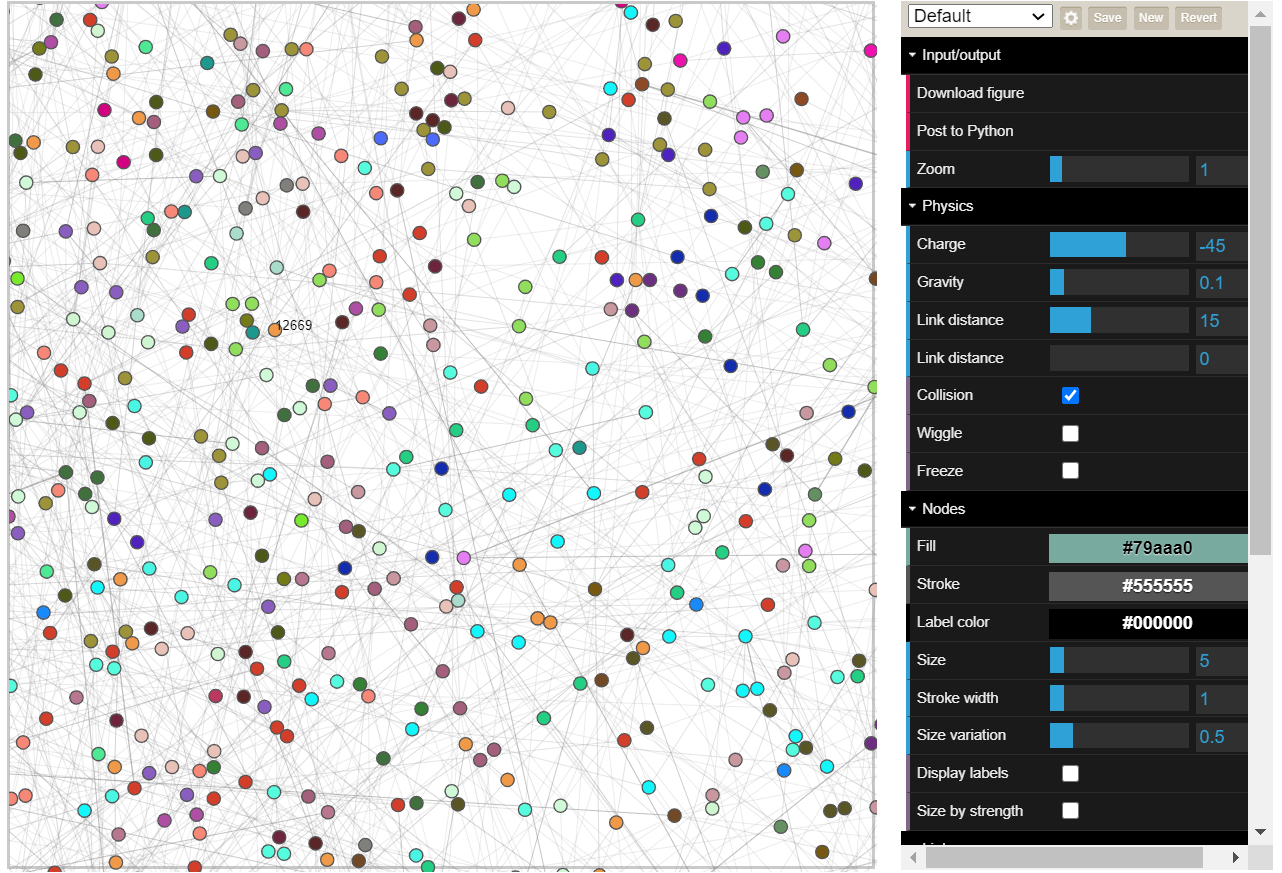

In [105]:
from PIL import Image
Image.open("img1.png")

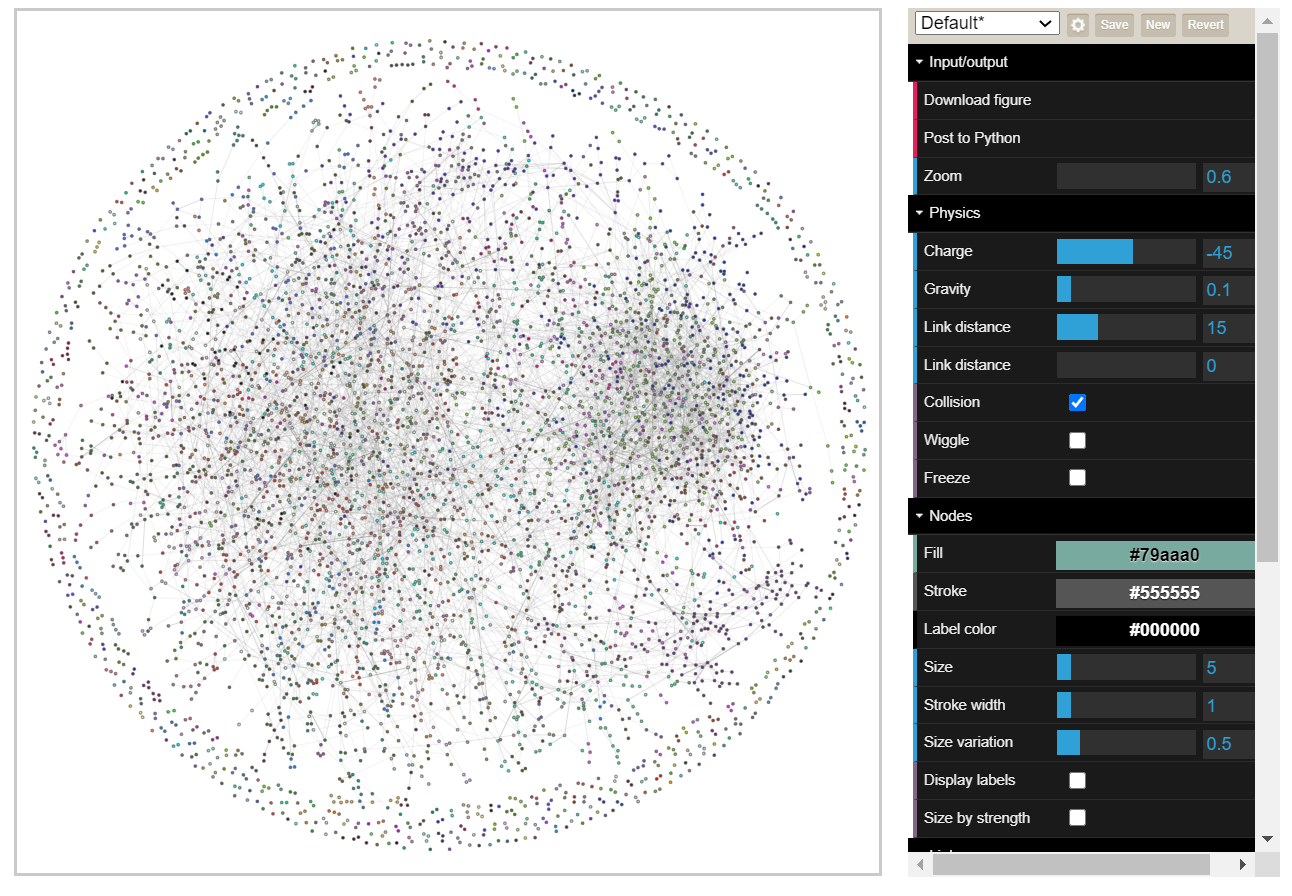

In [106]:
from PIL import Image
Image.open("img2.png")

> **Ex. 10.2.6:** Maybe the communities you observed in the previous exercise were not as pretty as you were hoping.
Admittedly, the Facebook wallpost network is not the most modular network anyway, but still it examplifies a serious
problem with the Modularity score as a utility function for community detection. Can you explain what this problem is,
and why it becomes increasingly severe as the network grows larger?
>
> *Hint: it has something to do with the null model that Modularity uses*.

#### Solution to Ex. 10.2.6

The issue is related to the null model as this model generates random graphs with the with the same degree sequence, however, with random edge placement. 
In the facebook network, there is a lot of small comminities/clusters which are sparsely connected and therefore not fully connected (thus, not cliques). As the modularity measure increases the most for small clusters with high link densities, then the facebook comminities are not as pretty as we were hoping.

> *Final note: there are many other community detection algorithms out there. Check out the [NetworkX docs](https://networkx.github.io/documentation/stable/reference/algorithms/community.html)
for some easy-to-use alternatives to Modularity. Also you may want to have a look at [Infomap](https://mapequation.github.io/infomap/python/)
especially if you are working with networks where links represent flow (like transactions, exchange, citations, hyperlinks, etc). It usually gives amazing results.*